# Data Preprocessing

In [9]:
#from ultralytics import YOLO
import numpy as np
import torch
#from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw,ImageFont

In [10]:
import os
import shutil

# Define paths
dataset_path = "/kaggle/input/genderdata/UTKFace"  # Read-only source
output_path = "/kaggle/working/dataset_faces"  # Writeable destination

# Create directories for training data
os.makedirs(f"{output_path}/Male", exist_ok=True)
os.makedirs(f"{output_path}/Female", exist_ok=True)

# Copy images to the corresponding folders
for filename in os.listdir(dataset_path):
    if filename.endswith(".jpg"):
        parts = filename.split("_")
        if len(parts) >= 2:
            gender = int(parts[1])  # Extract gender label
            source_file = os.path.join(dataset_path, filename)
            
            if gender == 0:
                dest_file = os.path.join(output_path, "Male", filename)
            elif gender == 1:
                dest_file = os.path.join(output_path, "Female", filename)
            
            shutil.copy(source_file, dest_file)  # Copy instead of move

print("Dataset organized successfully!")


Dataset organized successfully!


In [11]:
import os

# Paths to the Male and Female folders
male_path = os.path.join(output_path, "Male")
female_path = os.path.join(output_path, "Female")

# Count the number of images in each folder
num_male = len(os.listdir(male_path))
num_female = len(os.listdir(female_path))

print(f"Number of Male images: {num_male}")
print(f"Number of Female images: {num_female}")
print(f"Male to Female ratio: {num_male / num_female:.2f}")

Number of Male images: 12391
Number of Female images: 11317
Male to Female ratio: 1.09


In [12]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Set up paths for training and validation datasets
train_data_dir = "/kaggle/working/dataset_faces"
#####Mobile Net first saved model was on 224 ,224 now we try second one 256 256
image_size = (224, 224)  # Resize images to 224x224 for a pre-trained model like VGG16

# Use ImageDataGenerator for data augmentation
############Added more augmentations###########
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  
    channel_shift_range=0.1, 
    fill_mode="nearest",
    validation_split=0.2
)


# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary',  # Since it's a binary classification (Male or Female)
    subset='training'  # Use this subset for training
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Use this subset for validation
)


Found 18967 images belonging to 2 classes.
Found 4741 images belonging to 2 classes.


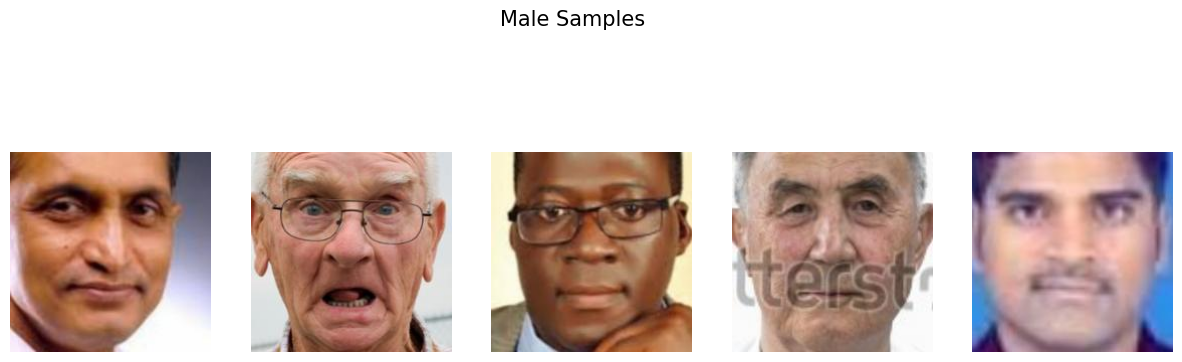

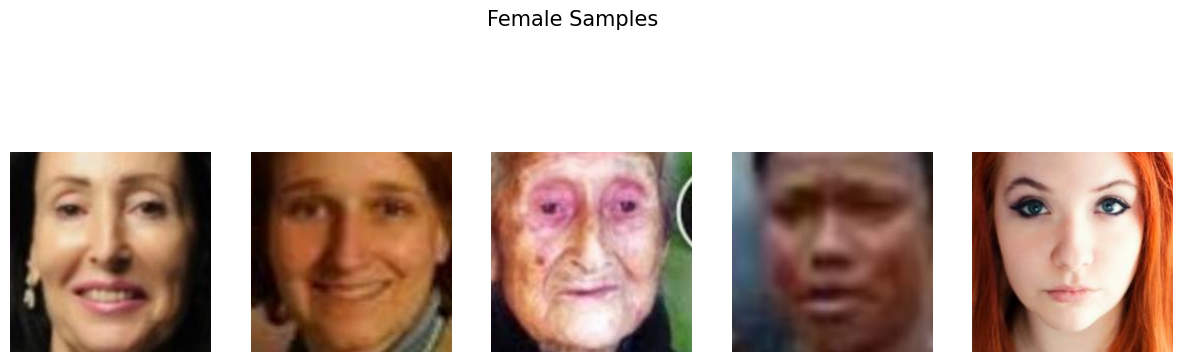

In [13]:
import matplotlib.pyplot as plt
import cv2
import random

# Function to visualize sample images
def show_sample_images(folder, title, num_samples=5):
    image_files = os.listdir(folder)
    random_images = random.sample(image_files, min(len(image_files), num_samples))
    
    fig, axes = plt.subplots(1, len(random_images), figsize=(15, 5))
    fig.suptitle(title, fontsize=15)
    
    for img_file, ax in zip(random_images, axes):
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        ax.imshow(img)
        ax.axis("off")
    
    plt.show()

# Show some male images
show_sample_images(os.path.join(train_data_dir, "Male"), "Male Samples")

# Show some female images
show_sample_images(os.path.join(train_data_dir, "Female"), "Female Samples")


# Final Model

In [14]:
from tensorflow.keras.models import load_model
model=load_model("/kaggle/input/gendermodel2/keras/default/1/mobilev2nettrial4_gender_classification.h5")

In [15]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 62s 394ms/step - accuracy: 0.8140 - loss: 0.4304
Validation Loss: 0.4296140968799591
Validation Accuracy: 0.8118540644645691


In [10]:
#####Trial 4####
from tensorflow.keras.layers import MaxPooling2D, Conv2D,Dense,Dropout,Flatten
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze the base model
genmodel4 = models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  
    tf.keras.layers.BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  
    tf.keras.layers.BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

#####Changed optimizer#####
genmodel4.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-4),
                 metrics=['accuracy'])
history4 = genmodel4.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 309s 497ms/step - accuracy: 0.5812 - loss: 7.2244 - val_accuracy: 0.5999 - val_loss: 5.9827
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 288s 481ms/step - accuracy: 0.6896 - loss: 5.5948 - val_accuracy: 0.6256 - val_loss: 4.7947
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 287s 479ms/step - accuracy: 0.7239 - loss: 4.4313 - val_accuracy: 0.6547 - val_loss: 3.8383
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 288s 481ms/step - accuracy: 0.7449 - loss: 3.5222 - val_accuracy: 0.6577 - val_loss: 3.0869
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 288s 481ms/step - accuracy: 0.7635 - loss: 2.8070 - val_accuracy: 0.6381 - val_loss: 2.5365
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 288s 481ms/step - accuracy: 0.7638 - loss: 2.2666 - val_accuracy: 0.6657 - val_loss: 2.0643
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 289s 482ms/step - accuracy: 0.7717 - loss: 1.8451 - val_accuracy: 0.6688 - val_loss: 1.7180
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 288s 482ms/step - accuracy: 0.7777 -

In [ ]:
####Fine tune model 4#####
# Unfreeze some layers in the base model for fine-tuning
base_model.trainable = True

# Recompile with a lower learning rate to prevent destroying pre-trained weights
genmodel4.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4),  
    metrics=['accuracy']
)
history4_finetune = genmodel4.fit(
    train_generator,
    epochs=30,  # Fine-tune for additional epochs
    validation_data=validation_generator
)
# Save in HDF5 format
genmodel4.save("mobilev2nettrial4_gender_classification.h5")

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 365s 531ms/step - accuracy: 0.7046 - loss: 0.6685 - val_accuracy: 0.5398 - val_loss: 1.2021
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 292s 488ms/step - accuracy: 0.7917 - loss: 0.5173 - val_accuracy: 0.6421 - val_loss: 0.7372
Epoch 3/30
 65/593 ━━━━━━━━━━━━━━━━━━━━ 3:28 394ms/step - accuracy: 0.8210 - loss: 0.4611

# Model 1

In [16]:
###TRIAL 1 ###
from tensorflow.keras.layers import MaxPooling2D, Conv2D,Dense,Dropout,Flatten
genmodel = models.Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid'))


genmodel.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics=['accuracy'])

In [17]:
history1 = genmodel.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 250s 405ms/step - accuracy: 0.6101 - loss: 0.6545 - val_accuracy: 0.6277 - val_loss: 0.6481
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 237s 395ms/step - accuracy: 0.7127 - loss: 0.5700 - val_accuracy: 0.6309 - val_loss: 0.6477
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 235s 393ms/step - accuracy: 0.7263 - loss: 0.5483 - val_accuracy: 0.6248 - val_loss: 0.6618
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 237s 396ms/step - accuracy: 0.7415 - loss: 0.5320 - val_accuracy: 0.6471 - val_loss: 0.6296
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 236s 394ms/step - accuracy: 0.7421 - loss: 0.5294 - val_accuracy: 0.6366 - val_loss: 0.6646
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 237s 396ms/step - accuracy: 0.7538 - loss: 0.5169 - val_accuracy: 0.6326 - val_loss: 0.6493
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 237s 395ms/step - accuracy: 0.7550 - loss: 0.5113 - val_accuracy: 0.6501 - val_loss: 0.6330
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 237s 396ms/step - accuracy: 0.7571 -

In [18]:
history1 = genmodel.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 237s 395ms/step - accuracy: 0.8018 - loss: 0.4441 - val_accuracy: 0.6695 - val_loss: 0.6186
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 236s 394ms/step - accuracy: 0.7974 - loss: 0.4410 - val_accuracy: 0.6408 - val_loss: 0.6454
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 235s 393ms/step - accuracy: 0.8045 - loss: 0.4365 - val_accuracy: 0.6775 - val_loss: 0.5891
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 235s 392ms/step - accuracy: 0.8063 - loss: 0.4311 - val_accuracy: 0.6958 - val_loss: 0.5967
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 236s 395ms/step - accuracy: 0.8127 - loss: 0.4244 - val_accuracy: 0.6794 - val_loss: 0.6000
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 235s 393ms/step - accuracy: 0.8103 - loss: 0.4263 - val_accuracy: 0.6657 - val_loss: 0.6327
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 235s 393ms/step - accuracy: 0.8154 - loss: 0.4142 - val_accuracy: 0.6794 - val_loss: 0.5904
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 236s 395ms/step - accuracy: 0.8142 -

In [20]:
genmodel.save("trial1_gender_model.h5")
print("Model saved successfully!")

Model saved successfully!


# Model2

In [ ]:
#### Trial 2
genmodel2 = models.Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

genmodel2.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics=['accuracy'])
history2 = genmodel2.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator
)
genmodel2.save("trial2_gender_model.h5")
print("Model saved successfully!")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 325s 535ms/step - accuracy: 0.5520 - loss: 0.6825 - val_accuracy: 0.6311 - val_loss: 0.6512
Epoch 2/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 300s 501ms/step - accuracy: 0.6763 - loss: 0.6122 - val_accuracy: 0.6195 - val_loss: 0.6753
Epoch 3/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 300s 501ms/step - accuracy: 0.7153 - loss: 0.5734 - val_accuracy: 0.6488 - val_loss: 0.6323
Epoch 4/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 298s 498ms/step - accuracy: 0.7276 - loss: 0.5534 - val_accuracy: 0.6313 - val_loss: 0.6547
Epoch 5/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 298s 498ms/step - accuracy: 0.7382 - loss: 0.5442 - val_accuracy: 0.6526 - val_loss: 0.6422
Epoch 6/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 319s 533ms/step - accuracy: 0.7505 - loss: 0.5209 - val_accuracy: 0.6465 - val_loss: 0.6489
Epoch 7/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 307s 512ms/step - accuracy: 0.7525 - loss: 0.5165 - val_accuracy: 0.6488 - val_loss: 0.6365
Epoch 8/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 312s 522ms/step - accuracy: 0.7686 -

# Model 3 (before last)

In [24]:
#####Trial 3####
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze the base model
genmodel3 = models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
#####Changed optimizer#####
genmodel3.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-4),
                 metrics=['accuracy'])
history3 = genmodel3.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


593/593 ━━━━━━━━━━━━━━━━━━━━ 316s 515ms/step - accuracy: 0.6476 - loss: 0.6426 - val_accuracy: 0.6454 - val_loss: 0.6403
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 292s 489ms/step - accuracy: 0.7472 - loss: 0.5272 - val_accuracy: 0.6693 - val_loss: 0.6079
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 295s 493ms/step - accuracy: 0.7634 - loss: 0.4973 - val_accuracy: 0.6598 - val_loss: 0.6347
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 291s 487ms/step - accuracy: 0.7733 - loss: 0.4806 - val_accuracy: 0.6855 - val_loss: 0.5947
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 290s 484ms/step - accuracy: 0.7761 - loss: 0.4690 - val_accuracy: 0.6623 - val_loss: 0.6257
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 291s 486ms/step - accuracy: 0.7864 - loss: 0.4598 - val_accuracy: 0.6838 - val_loss: 0.5911
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 291s 486ms/step - accuracy: 0.7904 - loss: 0.4596 - val_accuracy: 0.6807 - val_loss: 0.5952
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 286s 479ms/step - accuracy: 0.7941 - loss: 0.44

In [25]:
####Fine tune model 3#####
# Unfreeze some layers in the base model for fine-tuning
base_model.trainable = True

# Recompile with a lower learning rate to prevent destroying pre-trained weights
genmodel3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4),  
    metrics=['accuracy']
)
history_finetune = genmodel3.fit(
    train_generator,
    epochs=20,  # Fine-tune for additional epochs
    validation_data=validation_generator
)
# Save in HDF5 format
genmodel3.save("mobilev2net_gender_classification.h5")

Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 370s 539ms/step - accuracy: 0.6962 - loss: 0.5778 - val_accuracy: 0.5689 - val_loss: 0.8849
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 296s 495ms/step - accuracy: 0.8028 - loss: 0.4390 - val_accuracy: 0.6845 - val_loss: 0.5864
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 299s 500ms/step - accuracy: 0.8346 - loss: 0.3796 - val_accuracy: 0.7382 - val_loss: 0.5173
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 293s 490ms/step - accuracy: 0.8467 - loss: 0.3484 - val_accuracy: 0.7471 - val_loss: 0.4991
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 294s 491ms/step - accuracy: 0.8597 - loss: 0.3311 - val_accuracy: 0.7682 - val_loss: 0.4669
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 294s 492ms/step - accuracy: 0.8660 - loss: 0.3099 - val_accuracy: 0.7669 - val_loss: 0.4888
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 293s 490ms/step - accuracy: 0.8743 - loss: 0.2952 - val_accuracy: 0.7851 - val_loss: 0.4524
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 304s 508ms/step - accuracy: 0.8778 -

# Last model evaluation

In [119]:
import tensorflow as tf

# Load the saved model
model_path = "/kaggle/input/gendermodel2/keras/default/1/mobilev2nettrial4_gender_classification.h5"
genmodel4 = tf.keras.models.load_model(model_path)

print("Model loaded successfully!")

Model loaded successfully!


In [120]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions
predictions = genmodel4.predict(validation_generator)
predictions = (predictions > 0.5).astype(int)

# Get true labels
true_labels = validation_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)
print(cm)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


149/149 ━━━━━━━━━━━━━━━━━━━━ 69s 428ms/step
[[1209 1054]
 [1315 1163]]


# Train

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
from torch.utils.data import DataLoader

# Hyperparameters
BATCH_SIZE = 64  # Increased batch size for better generalization
EPOCHS = 15  # Train for more epochs
LR = 0.0005  # Lower learning rate for better convergence

# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Random flip to augment data
    transforms.RandomRotation(10),  # Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Dataset
train_dataset = datasets.ImageFolder("face_gender_dataset/train", transform=transform)
val_dataset = datasets.ImageFolder("face_gender_dataset/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Load Pretrained Model (EfficientNet or ResNet)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b3(pretrained=True)  # Better accuracy than ResNet50
model.classifier[1] = nn.Linear(1536, 2)  # Adjust for 2 classes
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Learning rate decay

# Training Loop with Validation
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    scheduler.step()  # Update learning rate

    # Validation Phase
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")

# Save Model
torch.save(model.state_dict(), "face_gender_model_best.pth")
print("Model saved successfully!")


# Evaluation

In [121]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load an image and preprocess it
img_path="/kaggle/input/gendertest/fall3.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # 🚨 Normalize the image before prediction!

predictions = genmodel4.predict(img_array)
predicted_class = "Female" if predictions < 0.5 else "Male"

print(f"Prediction: {predictions} --> Classified as: {predicted_class}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: [[    0.97148]] --> Classified as: Male


In [82]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.3 MB/s eta 0:00:00


In [122]:
import cv2
import numpy as np
from mtcnn import MTCNN
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load MTCNN face detector
detector = MTCNN()

# Load the trained gender classification model
genmodel4 = load_model("/kaggle/input/gendermodel2/keras/default/1/mobilev2nettrial4_gender_classification.h5")

# Function to detect and crop faces from an image
def extract_faces(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    detections = detector.detect_faces(img_rgb)  # Detect faces

    faces = []
    for detection in detections:
        x, y, width, height = detection["box"]
        x, y = max(0, x), max(0, y)  # Ensure no negative values

        face = img_rgb[y:y+height, x:x+width]  # Crop face
        face = cv2.resize(face, target_size)  # Resize to match model input
        face = image.img_to_array(face)
        face = np.expand_dims(face, axis=0) / 255.0  # Normalize

        faces.append(face)
    
    return faces

# Predict gender for each detected face
def predict_gender(img_path):
    faces = extract_faces(img_path)
    
    if not faces:
        print("No face detected!")
        return
    
    for i, face in enumerate(faces):
        prediction = genmodel4.predict(face)
        gender = "Female" if prediction < 0.5 else "Male"
        
        print(f"Face {i+1}: {gender} (Confidence: {prediction[0][0]:.4f})")

# Test with an image
predict_gender("/kaggle/input/gendertest/fall3.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Face 1: Male (Confidence: 0.5324)


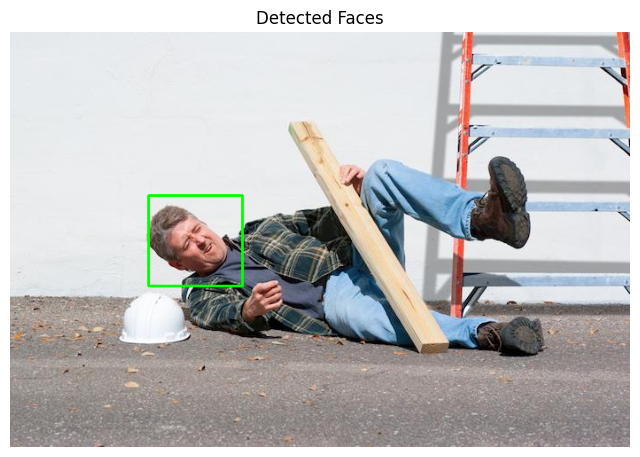

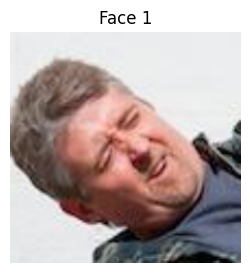

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
['Male']


In [123]:
import cv2
import numpy as np
from mtcnn import MTCNN
import matplotlib.pyplot as plt

# Initialize MTCNN detector
detector = MTCNN()

def detect_and_crop_faces(image_path, model_input_size=(224, 224)):
    # Read image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB (MTCNN works with RGB)

    # Detect faces
    faces = detector.detect_faces(img_rgb)
    
    cropped_faces = []
    for i, face in enumerate(faces):
        x, y, width, height = face['box']
        x, y = max(0, x), max(0, y)  # Ensure non-negative coordinates
        cropped_face = img_rgb[y:y+height, x:x+width]  # Crop face

        # Optionally, add a margin to the crop for better context around the face
        margin = 20  # This value can be adjusted
        x = max(0, x - margin)
        y = max(0, y - margin)
        width = min(img_rgb.shape[1], x + width + 2 * margin) - x
        height = min(img_rgb.shape[0], y + height + 2 * margin) - y
        cropped_face = img_rgb[y:y+height, x:x+width]
        
        # Resize the cropped face to the model's input size
        cropped_face_resized = cv2.resize(cropped_face, model_input_size)

        # Normalize the image (assuming model expects values in [0, 1] range)
        cropped_face_normalized = cropped_face_resized / 255.0

        cropped_faces.append(cropped_face_normalized)

        # Draw a rectangle around the face in the original image
        cv2.rectangle(img_rgb, (x, y), (x + width, y + height), (0, 255, 0), 2)

    # Show original image with detected faces
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Detected Faces")
    plt.show()

    # Show cropped faces
    for i, face in enumerate(cropped_faces):
        plt.figure(figsize=(3, 3))
        plt.imshow(face)
        plt.axis("off")
        plt.title(f"Face {i+1}")
        plt.show()

    return cropped_faces

# Example usage
cropped_faces = detect_and_crop_faces("/kaggle/input/gendertest/fall3.jpg")

# Convert list of cropped faces to a NumPy array (batch of faces)
cropped_faces_batch = np.array(cropped_faces)

# Now you can pass each cropped face to your gender model
predictions = genmodel4.predict(cropped_faces_batch)

# Assuming the model output is a probability (e.g., < 0.5 for female, >= 0.5 for male)
gender = ["Female" if p < 0.5 else "Male" for p in predictions]
print(gender)
